In [36]:
import os
import feedparser
import requests
import re
import folium

from shapely.geometry import box, shape, Polygon
import geopandas as gpd
import networkx as nx
import osmnx as ox
ox.settings.log_console=True
import rasterio.mask
import xmltodict

### Query OpenStreetMap data

In [ ]:
network_type="walk"
graph=ox.graph_from_bbox(aoi.total_bounds, network_type=network_type)

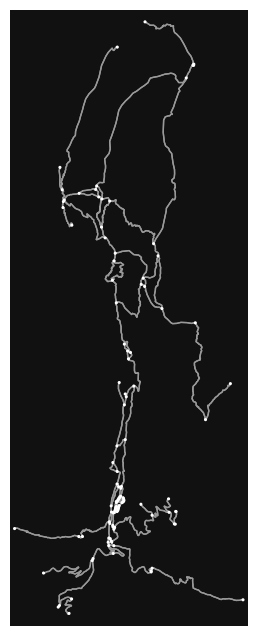

In [47]:
fig, ax = ox.plot_graph(graph, node_size=5)

In [48]:
out_file = ox.io.save_graph_geopackage(graph, filepath=f"aoi_{network_type}.gpkg")

### Access AOI data

In [41]:
path = r"../aoiGeojsonAndShp/aoi.geojson"
aoi = gpd.read_file(path)
aoi = aoi.set_crs(epsg=31255)
aoi = aoi.to_crs(epsg=3035)

In [42]:
aoi_geom = box(*aoi.total_bounds)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:3035")
aoi.total_bounds

array([4524323.94985785, 2658894.52162661, 4527067.19996231,
       2666120.45820499])

## Query Website

In [43]:
base = "https://data.bev.gv.at/geonetwork/srv/eng/csw"
params = {
    "service": "CSW",
    "request": "GetRecordById",
    "version": "2.0.2",
    "outputSchema": "http://www.isotc211.org/2005/gmd",
    "ElementSetName": "full",
    "id": "208cff7a-c8aa-42fe-bf4f-2b8156e37528"
}


r = requests.get(base, params=params, timeout=20)
print(r.status_code)
xml = r.text

200


In [44]:
doc = xmltodict.parse(xml)
record = doc['csw:GetRecordByIdResponse']['gmd:MD_Metadata']
ident = record['gmd:identificationInfo']['srv:SV_ServiceIdentification']

title = ident['gmd:citation']['gmd:CI_Citation']['gmd:title']['gco:CharacterString']
abstract = ident['gmd:abstract']['gco:CharacterString']

print("Title:", title)
print("Abstract:", abstract)


Title: AT.BEV ATOM Downloaddienst ALS EL Höhendaten
Abstract: Der ATOM Downloaddienst liefert unentgeltliche INSPIRE Höhendaten (Stichtag).


In [45]:
urls = []
dist = record.get('gmd:distributionInfo', {}).get('gmd:MD_Distribution', {})
if isinstance(dist, list):
    dist = dist[0]

transfer = dist.get('gmd:transferOptions', {})
if isinstance(transfer, list):
    transfer = transfer[0]

digital = transfer.get('gmd:MD_DigitalTransferOptions', {})
online = digital.get('gmd:onLine', [])
if not isinstance(online, list):
    online = [online]

for o in online:
    res = o.get('gmd:CI_OnlineResource', {})
    link = res.get('gmd:linkage', {}).get('gmd:URL')
    name = res.get('gmd:name', {}).get('gco:CharacterString')
    desc = res.get('gmd:description', {}).get('gco:CharacterString')
    if link:
        urls.append({'url': link, 'name': name, 'desc': desc})

for u in urls:
    print(f"{u['name'] or ''}: {u['url']} ({u['desc'] or ''})")

Informationen zum Produkt INSPIRE Downloaddienste: https://www.bev.gv.at/Services/Geoinformationsdienste/INSPIRE-Geodatendienste/INSPIRE-Downloaddienste.html ()
Metadaten AT.BEV ATOM Downloaddienst ALS EL Höhendaten: http://data.bev.gv.at/geonetwork/srv/eng/csw?service=CSW&request=GetRecordById&version=2.0.2&outputSchema=http%3A%2F%2Fwww.isotc211.org%2F2005%2Fgmd&ElementSetName=full&id=208cff7a-c8aa-42fe-bf4f-2b8156e37528 (GetRecordByIdResponse)
XML AT.BEV ATOM Downloaddienst ALS EL Höhendaten: https://data.bev.gv.at/geonetwork/srv/atom/describe/service?uuid=208cff7a-c8aa-42fe-bf4f-2b8156e37528 (Feed)


In [28]:
# feed_url = "https://data.bev.gv.at/geonetwork/srv/atom/describe/service?uuid=208cff7a-c8aa-42fe-bf4f-2b8156e37528"
# feed = feedparser.parse(feed_url)

# print(f"Feed title: {feed.feed.title}")
# print(f"Updated: {feed.feed.updated}")
# print(f"Entries: {len(feed.entries)}")

# for entry in feed.entries[:5]:  # show first few
#     print("\nTitle:", entry.title)
#     print("Updated:", entry.updated)
#     for link in entry.links:
#         print("  ", link.href)

In [46]:
# Query AOI
feed_url = "https://data.bev.gv.at/geonetwork/srv/atom/describe/service?uuid=208cff7a-c8aa-42fe-bf4f-2b8156e37528"
feed = feedparser.parse(feed_url)
entry = feed.entries[0]
print(entry.keys())

dict_keys(['inspire_dls_spatial_dataset_identifier_code', 'inspire_dls_spatial_dataset_identifier_namespace', 'tags', 'authors', 'author_detail', 'author', 'id', 'guidislink', 'link', 'links', 'rights', 'rights_detail', 'summary', 'summary_detail', 'title', 'title_detail', 'updated', 'updated_parsed', 'where'])


In [33]:

for entry in feed.entries:
    if "N2650000E4500000" and "DTM" in entry.title:
        print(entry.title)
        print(entry.where)
        for link in entry.links:
            print("  ", link.href)

ALS DTM CRS3035RES50000mN2550000E4650000 Höhenraster 1m Stichtag 15.09.2019
{'type': 'Polygon', 'coordinates': ([(14.24278, 45.95086), (14.24278, 46.42797), (14.92705, 46.42797), (14.92705, 45.95086), (14.24278, 45.95086)],)}
   https://data.bev.gv.at/geonetwork/srv/ger/csw?service=CSW&version=2.0.2&request=GetRecordById&outputschema=http://www.isotc211.org/2005/gmd&elementSetName=full&id=8b5cf388-9c94-4041-b8c0-048d54fc255d
   https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/8b5cf388-9c94-4041-b8c0-048d54fc255d&language=de
ALS DTM CRS3035RES50000mN2600000E4400000 Höhenraster 1m Stichtag 15.09.2019
{'type': 'Polygon', 'coordinates': ([(11.02827, 46.50017), (11.02827, 46.95853), (11.69323, 46.95853), (11.69323, 46.50017), (11.02827, 46.50017)],)}
   https://data.bev.gv.at/geonetwork/srv/ger/csw?service=CSW&version=2.0.2&request=GetRecordById&outputschema=http://www.isotc211.org/2005/gmd&elementSetName=full&id=c0f8fe44-1

In [ ]:
url_2021 = "https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/ddee933e-6023-49df-99e3-e8c49623eb46&language=de"
url_2022 = "https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/ee871d1d-aad0-4c85-89b7-076ec62265c0&language=de"
url_2023 = "https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/d3c8bfc0-6f95-4dda-921e-02ad0e89afe0&language=de"
url_2024 = "https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/4a2bbfb4-deb6-48d6-9433-03fc6c76cad2&language=de"
url_2019 = "https://data.bev.gv.at/geonetwork/srv/atom/describe/dataset?spatial_dataset_identifier_code=https://doi.org/10.48677/1b2e1d2d-8f55-4204-8c55-5305f41e663e&language=de"
urls = {
    # 2024: url_2024,
    2023: url_2023,
    2022: url_2022, 
    2021: url_2021, 
    2019: url_2019,
        }


out_dir = "ALS_DTM_AOI"
os.makedirs(out_dir, exist_ok=True)


In [52]:
def extract_tile_bounds(entry):
    try:
        where = entry['where']
        coords = where['coordinates'][0]
        tile_polygon = Polygon(coords)
        tile_gdf = gpd.GeoDataFrame([1], geometry=[tile_polygon], crs='EPSG:4326')
        tile_gdf = tile_gdf.to_crs('EPSG:3035')

        return tile_gdf.geometry.iloc[0]
    except Exception as e:
        print(f"Couldn't parse bounds: {e}")
        return None

In [ ]:
for year, url in urls.items():
    feed = feedparser.parse(url)
    print("Dataset title:", feed.feed.title)
    download_count = 0
    skipped_count = 0

    for entry in feed.entries:
        tile_geom = extract_tile_bounds(entry)

        if tile_geom is not None:
            if not tile_geom.intersects(aoi_geom):
                skipped_count += 1
                continue
            else:
                print(f"Entry: {entry.title}")
        else:
            print(f"No bounds found entry: {entry.title}")
        
        
        for link in entry.links:
            download_url = link.href
            filename=os.path.basename(download_url)
            output_path = os.path.join(out_dir, f"{year}_{filename}")
    
    r = requests.get(download_url, stream=True)
    r.raise_for_status()

In [55]:
import rasterio
from rasterio.mask import mask

for year, url in urls.items():
    feed = feedparser.parse(url)
    print(f"\n{'='*60}")
    print(f"Dataset: {feed.feed.title}, Year: {year}")
    print(f"{'='*60}")
    
    for entry in feed.entries:
        tile_geom = extract_tile_bounds(entry)
        
        if tile_geom is not None and not tile_geom.intersects(aoi_geom):
            continue
        
        print(f"Processing: {entry.title}")
        
        download_url = entry.links[0].href
        filename = os.path.basename(download_url)
        temp_path = os.path.join(out_dir, f"temp_{year}_{filename}")
        clipped_path = os.path.join(out_dir, f"{year}_clipped_{filename.replace('.zip', '.tif')}")
        
        # Download
        try:
            print(f"Downloading...")
            r = requests.get(download_url, stream=True)
            r.raise_for_status()
            
            with open(temp_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            raster_path = temp_path
            
            # Clip to AOI
            print(f" Clipping to AOI...")
            with rasterio.open(raster_path) as src:
                # Reproject AOI to match raster CRS if needed
                aoi_reprojected = aoi.to_crs(src.crs)
                
                # Clip
                out_image, out_transform = mask(src, aoi_reprojected.geometry, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                # Save clipped raster
                with rasterio.open(clipped_path, "w", **out_meta) as dest:
                    dest.write(out_image)
            
            # Remove original
            os.remove(raster_path)
            print(f"Saved clipped: {clipped_path}")
            
        except Exception as e:
            print(f"Error: {e}")


Dataset: INSPIRE Dataset ATOM feed: ALS DTM CRS3035RES50000mN2650000E4500000 Höhenraster 1m Stichtag 15.09.2024, Year: 2024
Processing: ALS DTM CRS3035RES50000mN2650000E4500000 Höhenraster 1m Stichtag 15.09.2024 in ETRS89 / LAEA Europe - TIFF/GeoTIFF files
    ↓ Downloading...


KeyboardInterrupt: 